<a href="https://colab.research.google.com/github/VasudhaMaddi/nlp/blob/main/Copy_of_NLPScript2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Optimal number of topics: 2
Topic: 0
Words: ['vulnerability', 'malware', 'device', 'server', 'file', 'code', 'could', 'password', 'using', 'malicious']
Topic: 1
Words: ['vulnerability', 'malware', 'information', 'company', 'server', 'code', 'website', 'window', 'exploit', 'malicious']


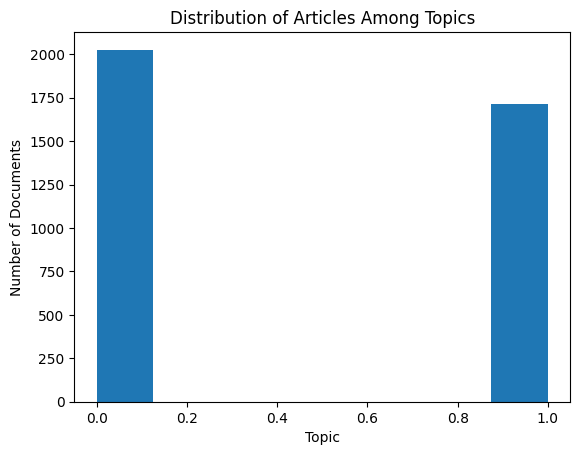

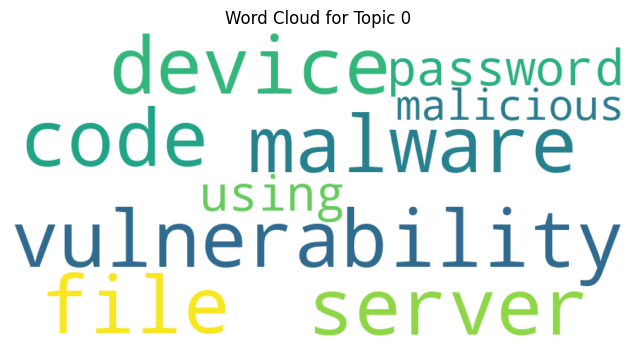

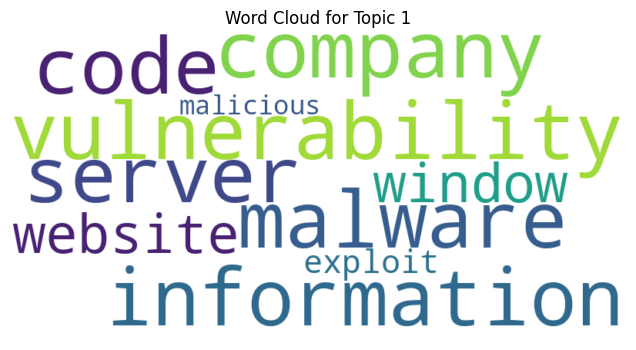

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the dataset
df = pd.read_excel("TheHackerNews_Dataset.xlsx")

# Function to clean and preprocess text data
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))  # Ensure text is converted to string
    # Convert to lowercase
    text = text.lower()
    return text

# Function to tokenize and lemmatize text
def tokenize_and_lemmatize(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Apply text preprocessing
df['clean_content'] = df['Article'].apply(clean_text)
df['tokens'] = df['clean_content'].apply(tokenize_and_lemmatize)

# Create a dictionary representation of the documents
dictionary = Dictionary(df['tokens'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

# Function to compute coherence score for a given number of topics
def compute_coherence_score(corpus, dictionary, k):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# Determine the optimal number of topics
min_topics = 2
max_topics = 10
coherence_scores = []

for k in range(min_topics, max_topics + 1):
    coherence_score = compute_coherence_score(corpus, dictionary, k)
    coherence_scores.append(coherence_score)

optimal_num_topics = min_topics + coherence_scores.index(max(coherence_scores))
print("Optimal number of topics:", optimal_num_topics)

# Train the LDA model with the optimal number of topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics)

# Visualize topics
topics = lda_model.show_topics(formatted=False)
for topic_num, words in topics:
    print("Topic:", topic_num)
    print("Words:", [word[0] for word in words])

# Visualize the distribution of articles among topics
# Extract topic distributions from the LDA model
topic_distribution = [lda_model[doc] for doc in corpus]

# Determine the optimal number of topics based on coherence scores
optimal_num_topics = 8  # Update this based on your analysis

# Visualize the distribution of articles among topics
# Create an array with zeros for each document and topic
doc_topic_matrix = np.zeros((len(topic_distribution), optimal_num_topics))

# Fill the matrix with actual topic proportions
for doc_index, doc_topics in enumerate(topic_distribution):
    for topic_index, proportion in doc_topics:
        doc_topic_matrix[doc_index, topic_index] = proportion

# Plot the distribution
plt.hist(np.argmax(doc_topic_matrix, axis=1), bins=optimal_num_topics, align='mid')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Distribution of Articles Among Topics')
plt.show()

# Generate word clouds for each topic
for topic_num, words in topics:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([word[0] for word in words]))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Topic {}'.format(topic_num))
    plt.show()
